## 1.0 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xgb
import random
import warnings
warnings.filterwarnings('ignore')
import pickle
from flask import Flask, Response
import requests


### 1.1 Helper functions

In [26]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = k - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1))) # v de cramer vai de 0 até 1

def mean_percentage_error(y, yhat):
    return np.mean((y-yhat/y))

def ml_error( model_name, y, yhat ):
    mae = mt.mean_absolute_error( y, yhat )
    mape = mt.mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mt.mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )

def cross_validation (x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []

    k = 1
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'\nKFold number {k}')
        # start and end date for validation
        val_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        val_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < val_start_date]
        validation = x_training[(x_training['date'] >= val_start_date) & (x_training['date'] <= val_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model

        # fit
        m.fit(xtraining, ytraining)

        # predict
        yhat_m = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat_m))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({"Model Name": model_name,
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 2.0 Load datasets

In [2]:
df_sales_raw = pd.read_csv('./datasets/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('./datasets/store.csv', low_memory=False)

# merge files
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on= 'Store')


In [28]:
# backup
df1 = df_raw.copy()

## 3.0 Data description

### 3.1 Rename collumns

In [29]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns =  cols_new

### 3.2 Data Dimension

In [30]:
df1.shape

(1017209, 18)

### 3.3 Data types

In [31]:
df1['date'] = pd.to_datetime(df1["date"]) # convertendo a coluna date de string para data
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 3.4 Check NA

In [32]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 3.5 Fillout NA

In [33]:
#competition_distance      
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis = 1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis = 1)    

#promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis = 1)

#promo2_since_year     
df1['promo2_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis = 1)

#promo_interval 
month_map = {1: 'jan', 2: 'fev', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'out', 11: 'nov', 12: 'dec'} 
df1.fillna({'promo_interval':0}, inplace=True)  
df1["month_map"] = df1['date'].dt.month.map(month_map) # numeros substituidos pelas letras   
df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x['promo_interval'].split(',') else 0, axis = 1) # axis = 1 aplicada função apply nas colunas

### 3.6 Change Types

In [34]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [35]:
# selecionando os tipos de variáveis
num_atributes = df1.select_dtypes(include= ['int64', 'float64'])
cat_atributes = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

#### 3.7.1 Numerical atributes statistical

In [36]:
# central tendences metrics - median, mean
ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

# dispersion - std, min, max, range, kurtosis
d1 = pd.DataFrame(num_atributes.apply(np.std)).T
d2 = pd.DataFrame(num_atributes.apply(max)).T
d3 = pd.DataFrame(num_atributes.apply(min)).T
d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributes','min','max','range','mean','median','std','skew','kurtosis']
m

# skew próxima de 0, próxima de uma normal - quanto maior a skew, mais próxima da esquerda no gráfico de distribuição, estará
# kurtosis perto de 1, não tem pico muito elevado

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1115.0,1.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,7.0,1.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,41551.0,0.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,7388.0,0.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,1.0,0.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,1.0,0.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,1.0,0.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,200000.0,20.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,12.0,1.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2015.0,1900.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


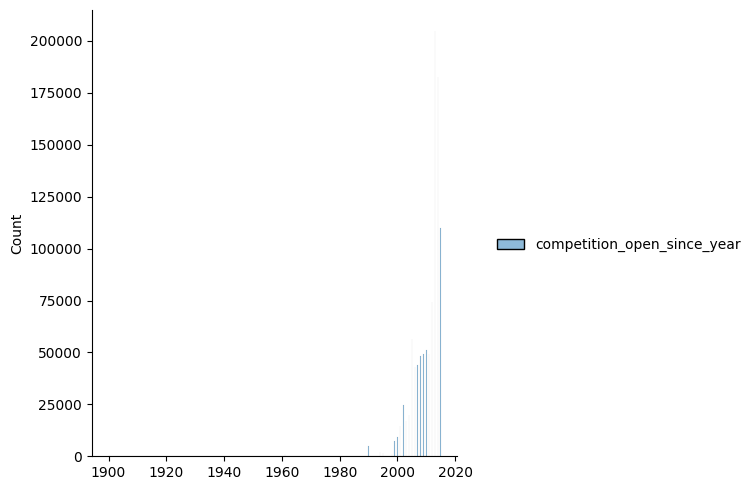

In [37]:
sns.displot([df1["competition_open_since_year"]]);

#### 3.7.2 Categorical atributes statistical

In [38]:
cat_atributes.apply(lambda x: x.nunique())

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

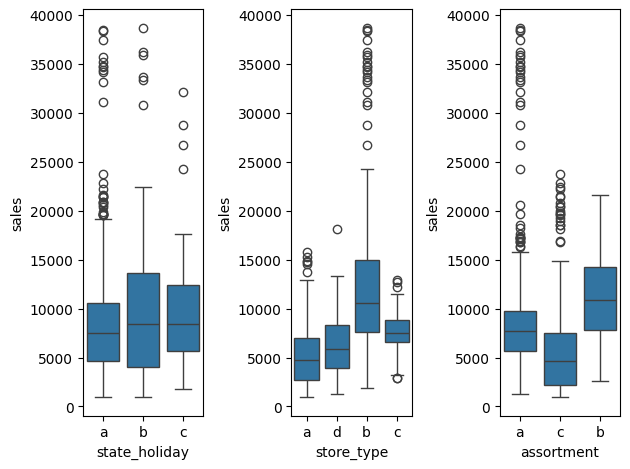

In [39]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x ='state_holiday' , y = 'sales' , data = aux1 );

plt.subplot(1,3,2)
sns.boxplot(x ='store_type' , y = 'sales' , data = aux1 );

plt.subplot(1,3,3)
sns.boxplot(x ='assortment' , y = 'sales' , data = aux1 );
plt.tight_layout()  
plt.show()


## 4.0 Feature Engineering

In [40]:
df2 = df1.copy()

#### 4.1 Mind map hypotesis

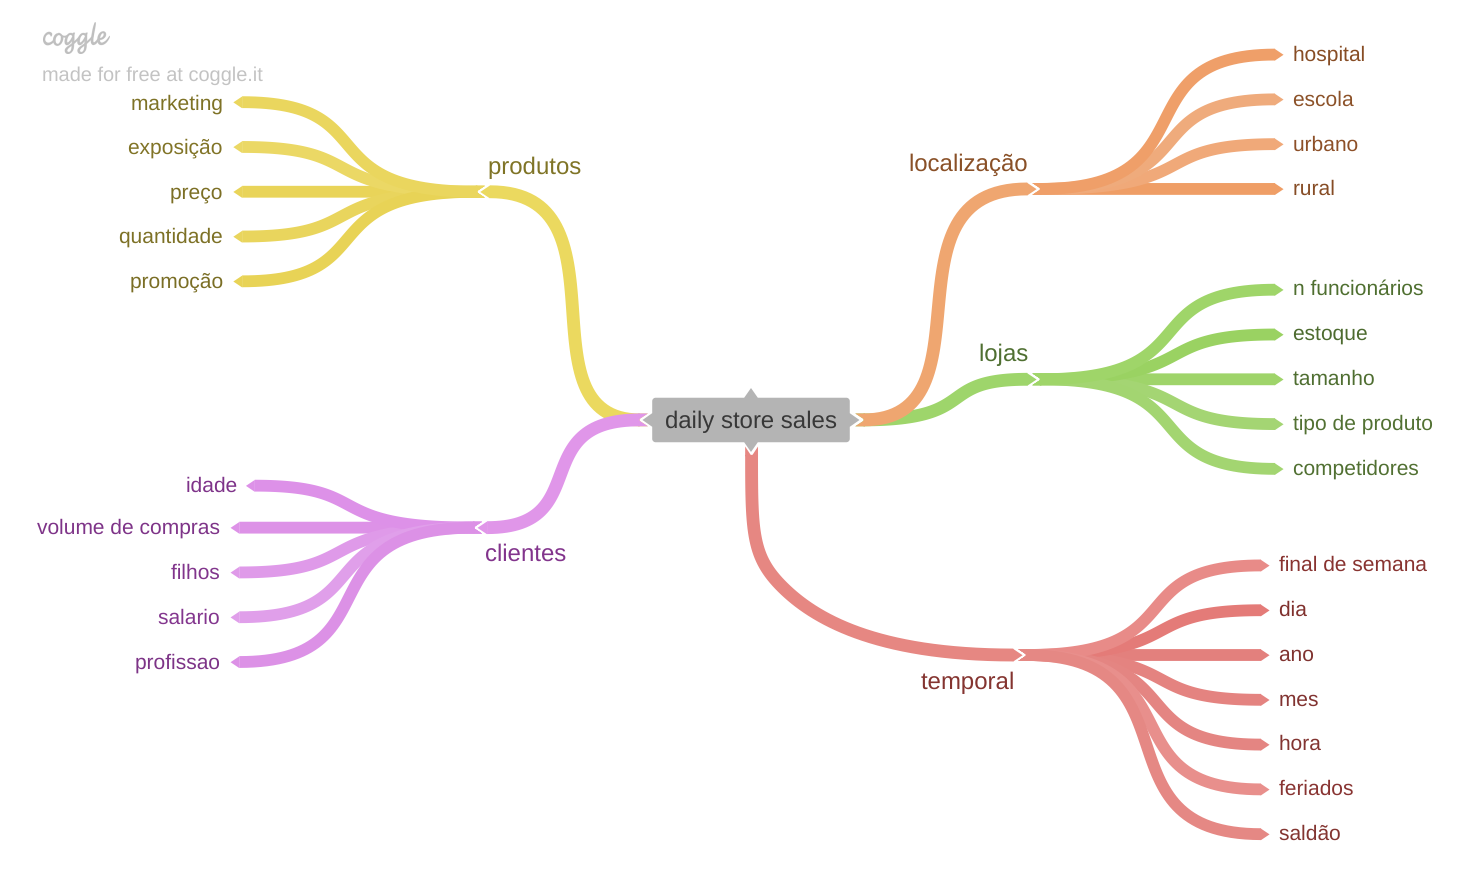

In [41]:
Image('img/mind_map_hypotesis.png') # coogle

#### 4.2 Hypotesis creation

##### 4.2.1 Store hypotesis

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

##### 4.2.2 Product hypotesis

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.


##### 4.2.3 Time hypotesis

1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.


#### 4.3 Final hypotesis list

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

### 4.4 Feature Engeeniring

In [42]:
# year
df2['year'] = df2["date"].dt.year

# month
df2['month'] = df2["date"].dt.month

# day
df2['day'] = df2["date"].dt.day

# week of year
df2['week_of_year'] = df2["date"].dt.strftime('%U').astype(int)

# year week
df2['year_week'] = df2["date"].dt.strftime('%y-%w')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+  df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)                               

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else  'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else  'easter_holiday' if x=='b' else 'christmas' if x =='c' else 'regular_day')

### 4.5 Filtragem de variáveis

In [43]:
df3= df2.copy()

#### 4.5.1 Filtragem das linhas

In [44]:
df3 = df3[(df3['open']!=0) & (df3['sales']> 0)]

#### 4.5.2 Seleção das colunas

In [45]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

## 5.0 Exploratory Data Analysis

In [46]:
df4 = df3.copy()

### 5.1 Análise Univariada

#### 5.1.1 Responde variable

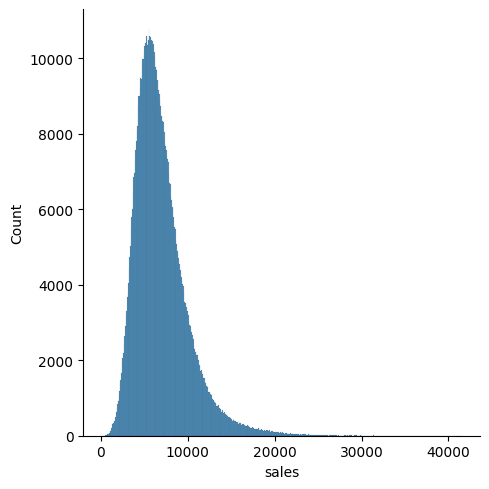

In [47]:
sns.displot(df4['sales']);

#### 5.1.2 Numerical Variables

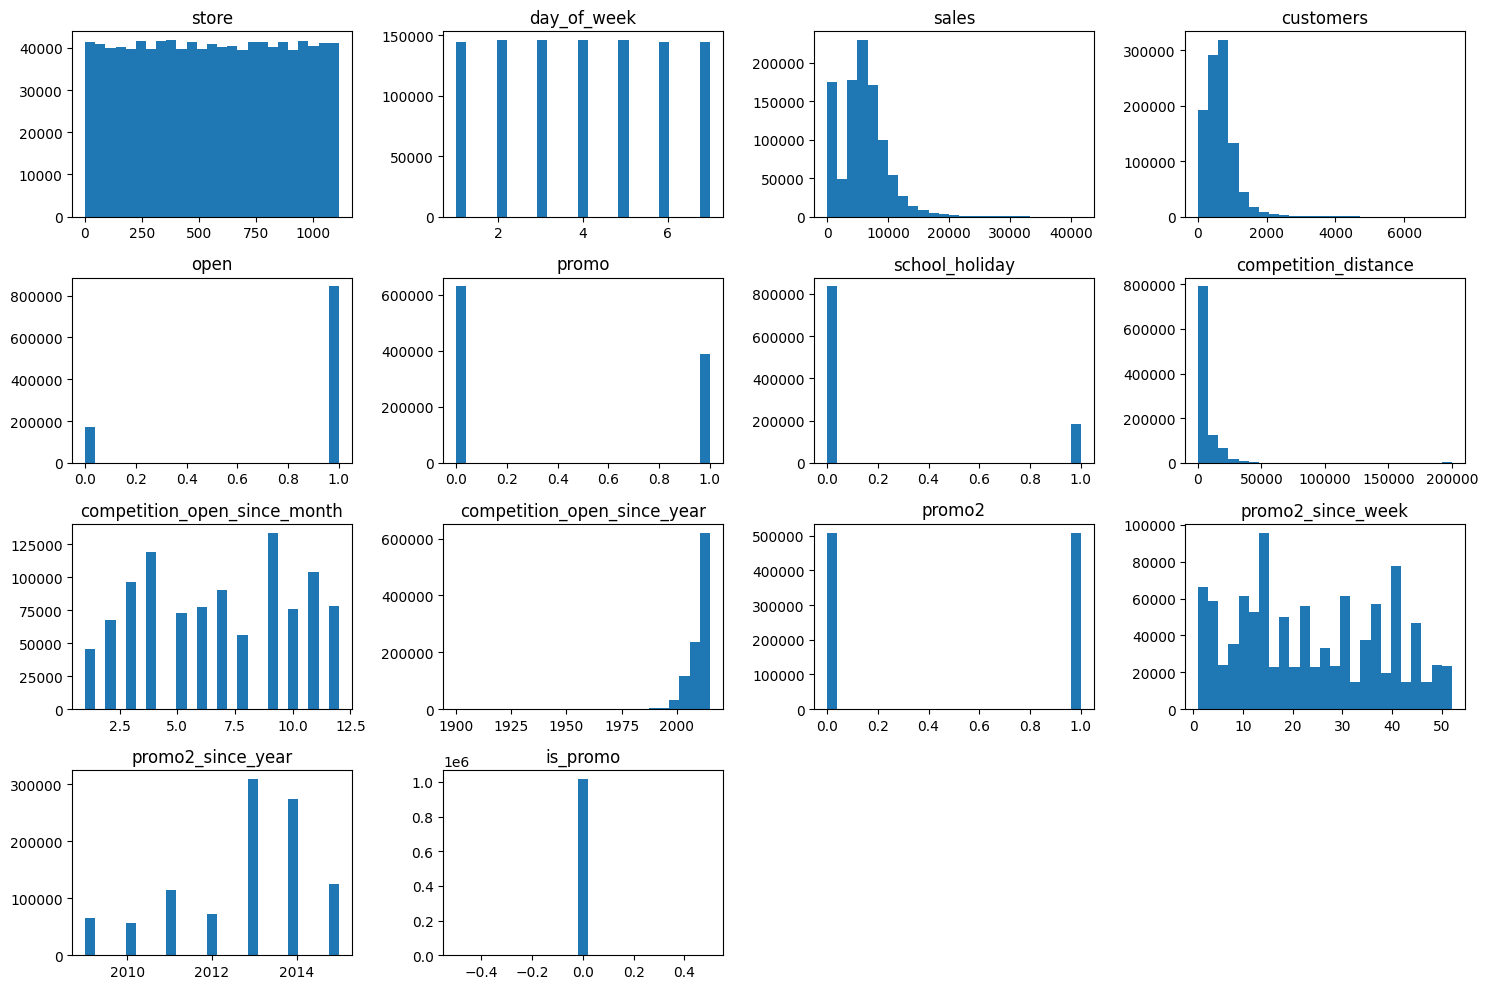

In [48]:
num_atributes.hist(bins=25, figsize=(15, 10), grid = False);
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de gráficos
plt.show()


#### 5.1.3 Categorical Variables

In [49]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

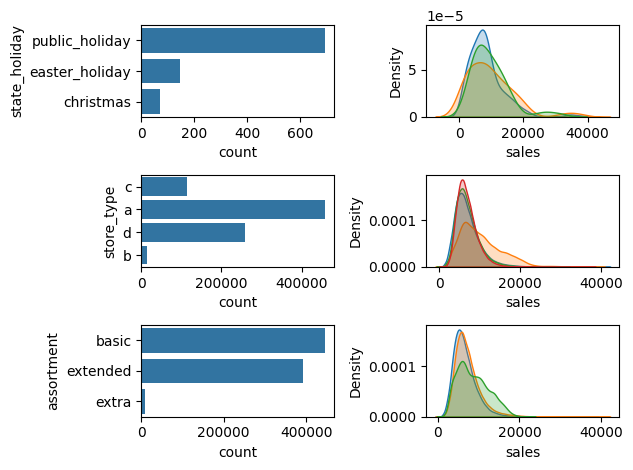

In [50]:
# state holiday
plt.subplot(3,2,1);
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2);
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True);

# store type
plt.subplot(3,2,3);
sns.countplot(df4['store_type']);

plt.subplot(3,2,4);
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True);

# assortment
plt.subplot(3,2,5);
sns.countplot(df4['assortment']);

plt.subplot(3,2,6);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True);
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de gráficos
plt.show()


### 5.2 Análise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais.
***FALSA*** lojas com MAIOR SORTIMENTO vendem MENOS

<Axes: xlabel='year_week'>

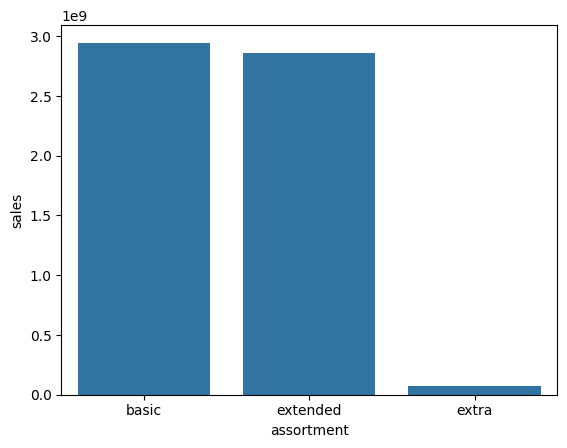

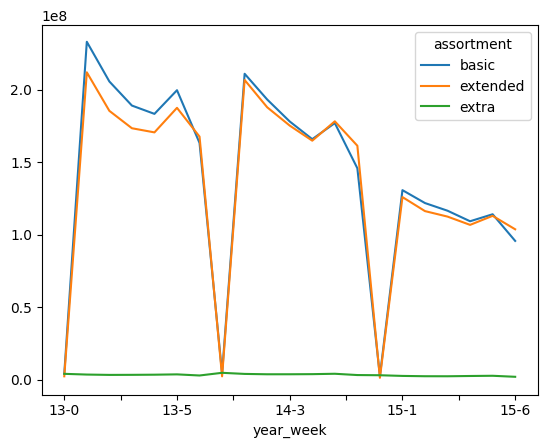

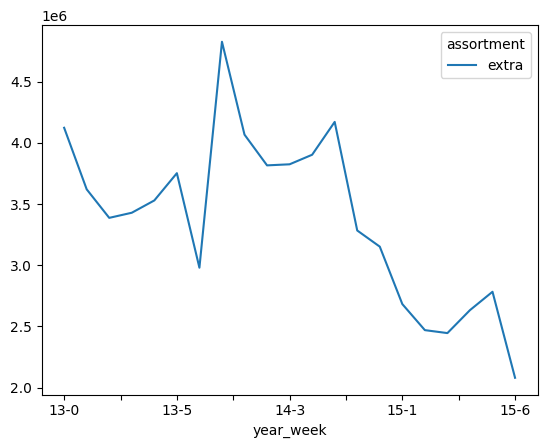

In [51]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values = 'sales').plot()

#### H2. Lojas com competidores mais próximos deveriam vender menos.
***FALSA*** Lojas com competidores mais próximos vendem mais


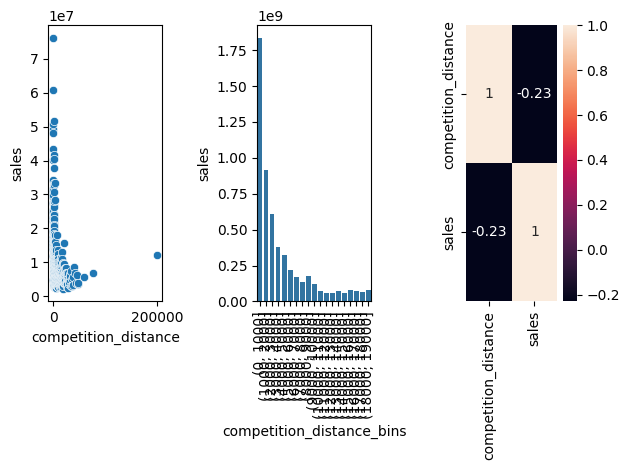

In [52]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y = 'sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_bins'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_bins', 'sales']].groupby('competition_distance_bins').sum().reset_index()
sns.barplot(x= 'competition_distance_bins', y='sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True)
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de gráficos
plt.show()


#### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com competidores a  mais próximos vendem menos

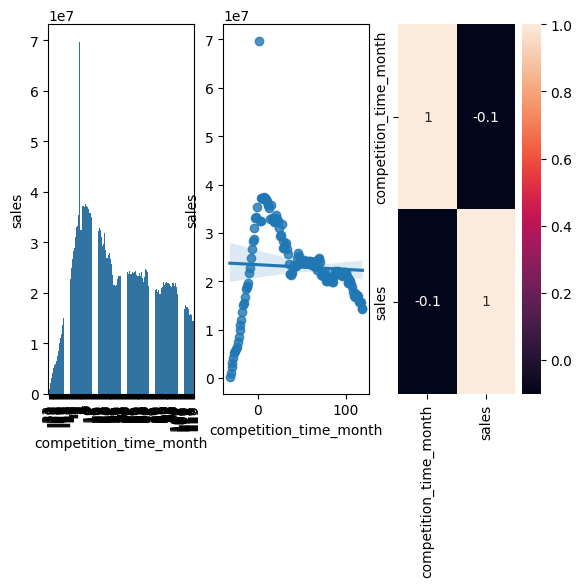

In [53]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data = aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA*** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

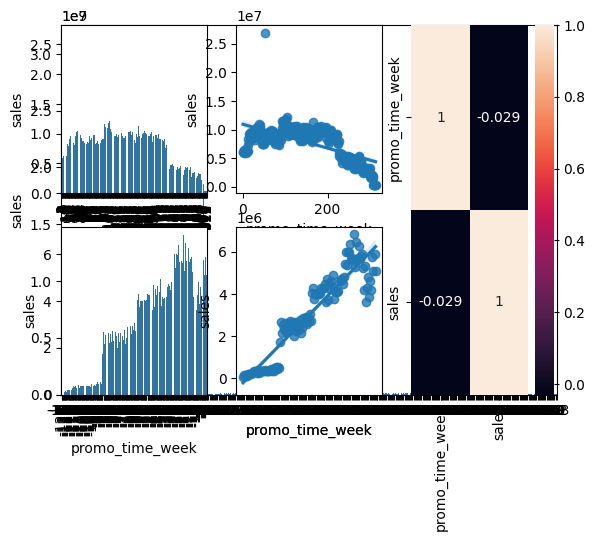

In [54]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']> 0] # promo extendida
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']< 0] # promo tradicional
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method= 'pearson'), annot = True);

#### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
***FALSA*** lojas com mais promoções consecutivas vendem menos


In [55]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


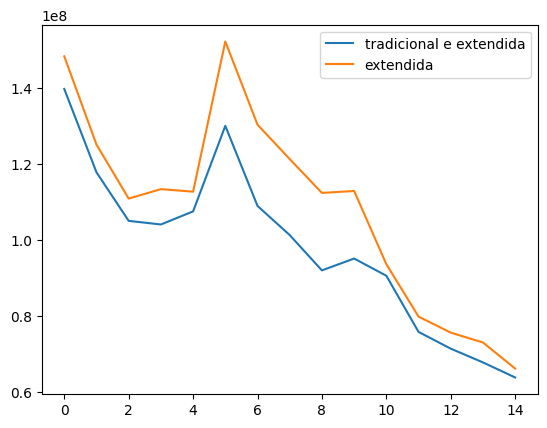

In [56]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['tradicional e extendida', 'extendida']);

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
***FALSA*** lojas abertas durante o feriado de natal vendem menos


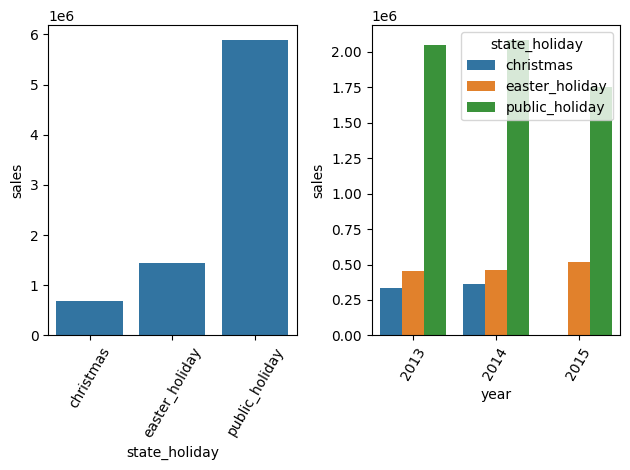

In [57]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1);
plt.xticks(rotation = 60)
;

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y ='sales', hue = 'state_holiday', data = aux2);
plt.xticks(rotation = 60);
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de gráficos
plt.show()


#### H8. Lojas deveriam vender mais ao longo dos anos.
***FALSA*** Lojas vendem menos ao longo dos anos


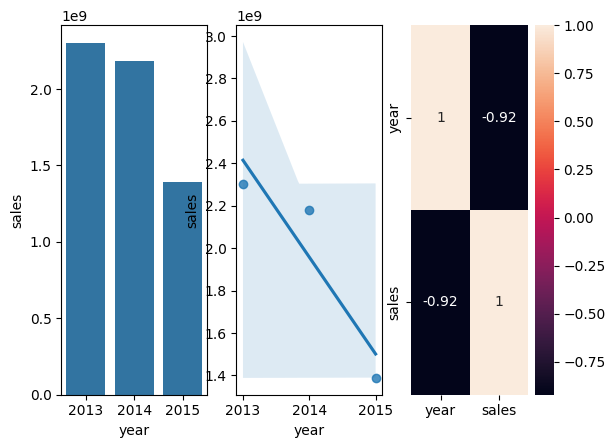

In [58]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H9. Lojas deveriam vender mais no segundo semestre do ano.
***FALSA*** lojas vendem menos no segundo semestre do ano

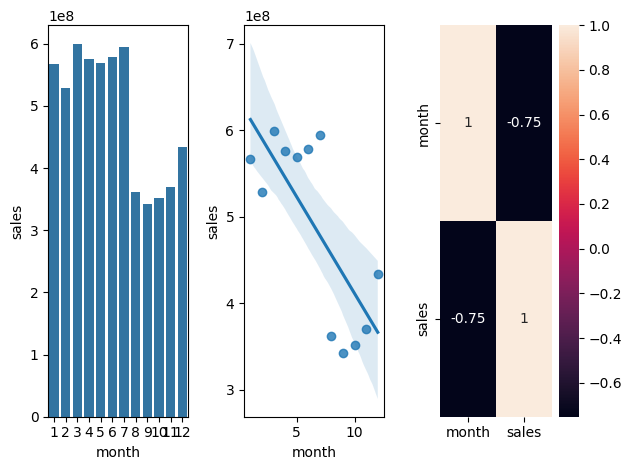

In [59]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de gráficos
plt.show()

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
***VERDADEIRA*** lojas vendem mais depois do dia 10 de cada mes


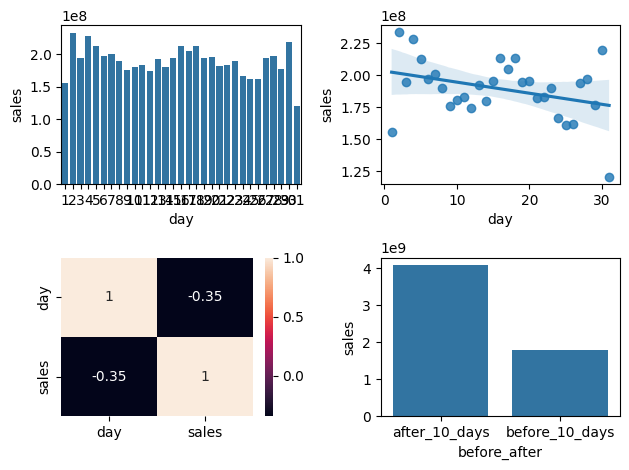

In [60]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y = 'sales', data = aux1);


plt.subplot(2,2,2)
sns.regplot(x='day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10 else  'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y = 'sales', data = aux2);
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de gráficos
plt.show()

#### H11. Lojas deveriam vender menos aos finais de semana.
***VERDADEIRA*** lojas vendem menmos nos finais de semana


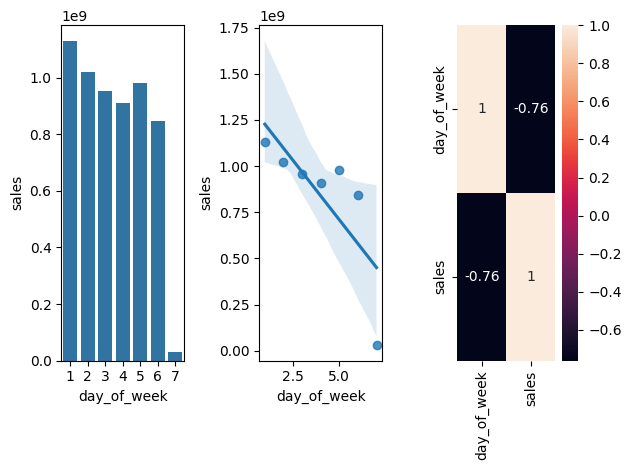

In [61]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y = 'sales', data = aux1);


plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);
plt.tight_layout()  
plt.show()

#### H12. Lojas deveriam vender menos durante os feriados escolares.
***VERDADEIRA*** lojas vendem menos durante feriados escolares, exceto para o mês de agosto

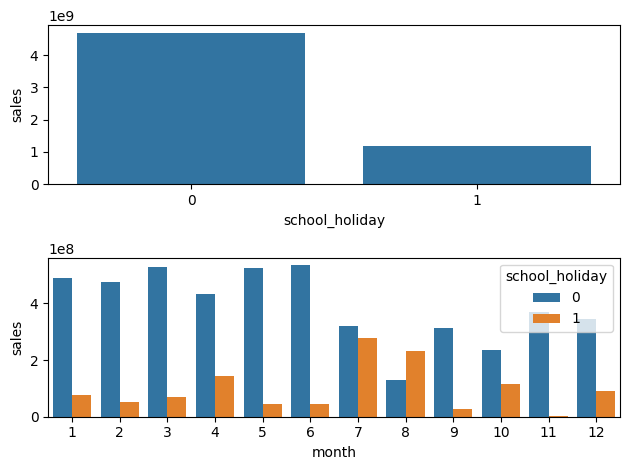

In [62]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y = 'sales', hue = 'school_holiday', data = aux2);
plt.tight_layout()  
plt.show()

### 5.3 Análise Multivariada

#### 5.3.1 Numerical atributes

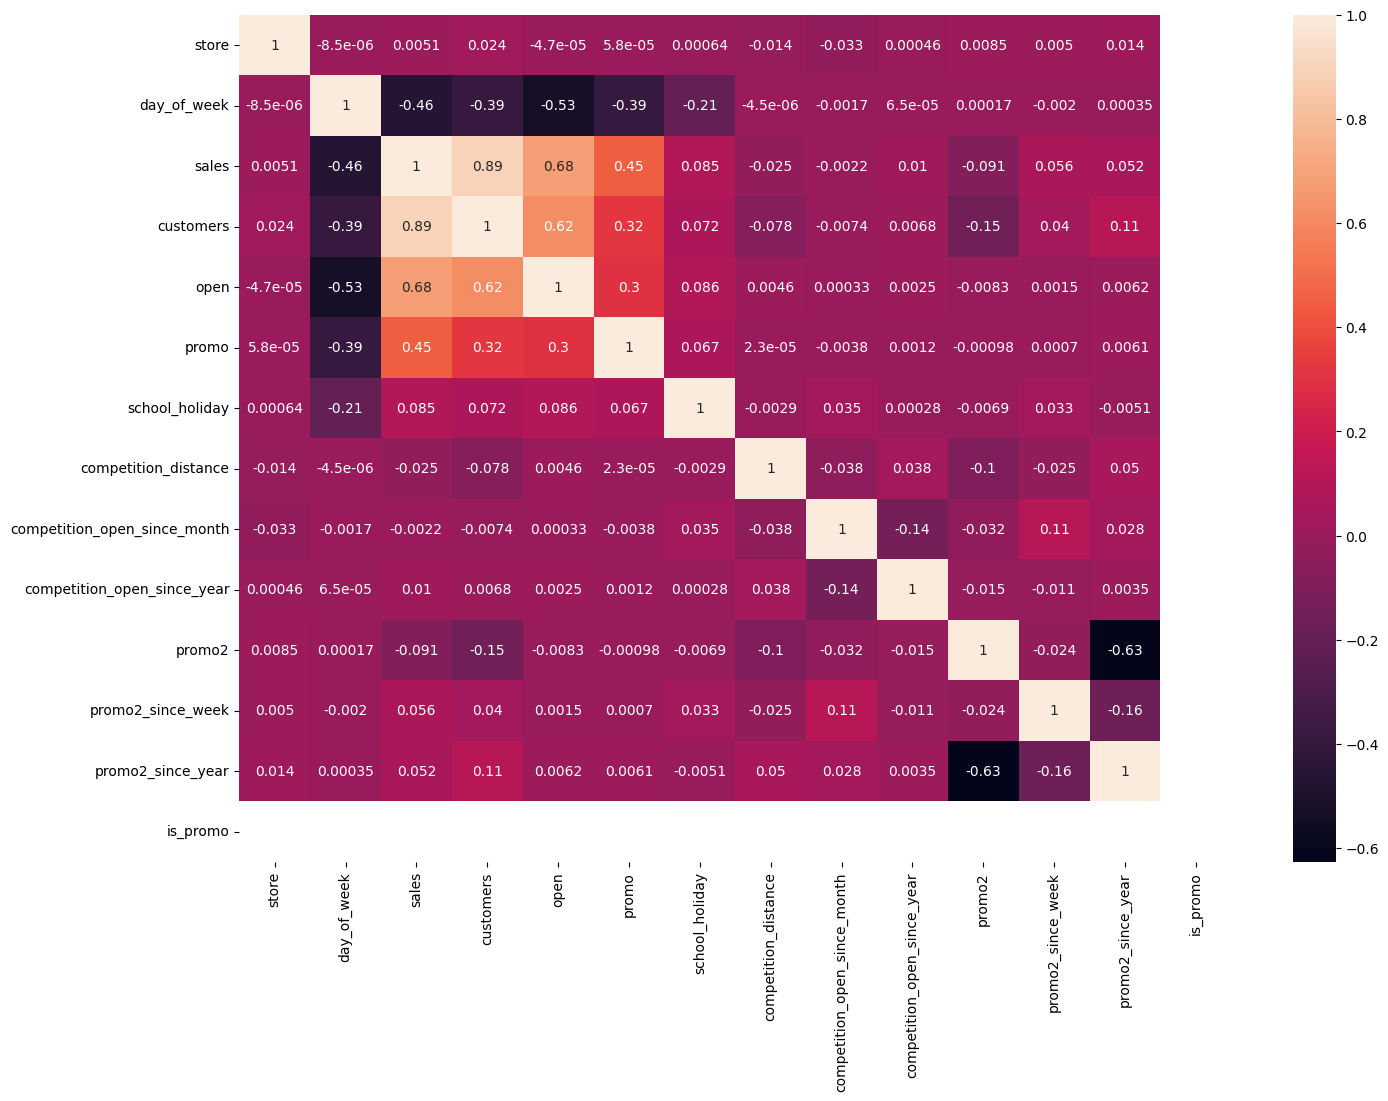

In [63]:
correlation = num_atributes.corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(16, 11))
ax = sns.heatmap(correlation, annot = True, ax= ax);
plt.show()


#### 5.3.2 Categorical atributes

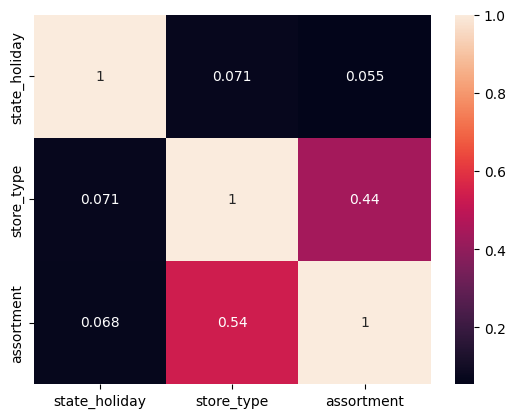

In [64]:
# only categorical data
a = df4.select_dtypes(include = 'object')

# calculate cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True);

## 6.0 Data preparation

In [65]:
df5 = df4.copy()

### 6.1 Normalization

In [66]:
## Sem variáveis com distriuição normal

# N = (valor - média)/desvio pad

### 6.2 Rescaling

In [67]:
a = df5.select_dtypes(include = ['int64', 'float64'])

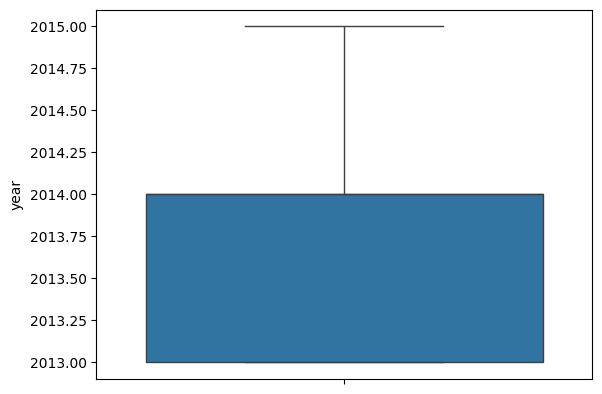

In [68]:
# análise de outliers
sns.boxplot(df5['year']);

In [69]:
# Robust scaler - para distribuições não normais com outliers
rs = RobustScaler()
mms = MinMaxScaler()

# Competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(rs, open('parameter/year_scaler.pkl','wb'))

### 6.3 Transformation

#### 6.3.1 Encoding

In [70]:
b = df5.select_dtypes(exclude = ['float64', 'int64'])
b.columns

Index(['date', 'state_holiday', 'store_type', 'assortment', 'month', 'day',
       'year_week', 'competition_since', 'promo_since'],
      dtype='object')

In [71]:
# state holiday - one hot enconding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns= ['state_holiday'])

# store type - label enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment
# ordinary enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 6.3.2 Response variable transformation

In [72]:
# Normalizando a  variável resposta 
df5['sales'] = np.log1p(df5['sales'])

#### 6.3.3 Nature transformation

In [73]:
# year nao é cíclico pq nao voltamos no tempo
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))


## 7.0 Feature selection

In [74]:
df6 = df5.copy()

In [75]:
# Removendo as colunas que não são importantes

cols_drop = ['week_of_year','day_of_week','day','month', 'promo_since', 'competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

### 7.1 Split dataset

In [76]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7) # não considerando as 6 última emanas

Timestamp('2015-06-19 00:00:00')

In [77]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

### 7.2 Boruta as feature selector

In [78]:
# training and test dataset for boruta
x_train_n = x_train.drop(['sales', 'date'], axis = 1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1) # n_jobs para optimizar o processador da máquina em paralelo

# define boruta
#boruta = BorutaPy(rf, n_estimators= 'auto', verbose = 2, random_state= 42).fit(x_train_n, y_train_n) # _n para transformar em vetor, pois o boruta não aceita o formato dataframe

#### 7.2.1 Best features from boruta

In [79]:
cols_selected = boruta.support_.tolist()

#best features
x_train_fs = x_train.drop(['date', 'sales'], axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

NameError: name 'boruta' is not defined

In [ ]:
cols_selected_boruta

NameError: name 'cols_selected_boruta' is not defined

### 7.3. Manual feature selection

In [80]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# columns to add
feat_to_add = ['sales', 'date']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 8.0 Machine Learning Modeling

In [81]:
X_train = x_train[ cols_selected_boruta ]
X_test = x_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = x_train[ cols_selected_boruta_full]

### 8.1 Average Model

In [82]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline) ) # expm1 para tirar o log da variável resposta
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 8.2 Linear Regression Model

In [83]:
# model
lr = LinearRegression()

# fit
lr.fit(X_train, y_train)

# predict
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.436765,0.297113,2664.582531


#### 8.2.1 Linear Regression Model - Cross validation

In [84]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2078.87+/-313.77,0.3+/-0.01,2969.89+/-484.48


### 8.3 Linear Regularization Model - Ridge

In [85]:
# model
ridge = Ridge(alpha = 1)

# fit
ridge.fit(X_train, y_train)

# predict
yhat_ridge = ridge.predict(X_test)

# performance
ridge_result = ml_error('Linear Regression - Ridge', np.expm1(y_test), np.expm1(yhat_ridge))
ridge_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Ridge,1872.485116,0.297116,2664.688692


#### 8.3.1 Linear Regression Model Ridge - Cross validation

In [86]:
ridge_result_cv = cross_validation(x_training, 5, 'Linear Regression Ridge', ridge, verbose = False)
ridge_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Ridge,2078.88+/-313.8,0.3+/-0.01,2969.94+/-484.5


### 8.4 Random Forest Model

In [87]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state= 42)

# fit
rf.fit(X_train, y_train)

# predict
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,744.786316,0.111095,1091.524868


#### 8.4.1 Random Forest - Cross validation

In [ ]:
#forest_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose = False)
#forest_cv

In [88]:
forest_cv = pd.DataFrame({"Model Name": "Random Forest",
                          "MAE CV": str(849.93) + "+/-" + str(237.86),
                          "MAPE CV": str(0.12) + "+/-" + str(0.03),
                          "RMSE CV": str(1270.58) + "+/-" + str(346.71)}, index = [0])
forest_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,849.93+/-237.86,0.12+/-0.03,1270.58+/-346.71


### 8.5 XGBoost Model

In [89]:
# model
model_xgb = xgb.XGBRegressor(objective= 'reg:squarederror', 
                             n_estimators = 100, 
                             eta = 0.01, 
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9)

# fit
model_xgb.fit(X_train, y_train)

# predict
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1675.22403,0.249711,2446.361878


#### 8.5.1 XGBoost - Cross validation

In [90]:
xgb_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_cv


KFold number 5

KFold number 4

KFold number 3

KFold number 2

KFold number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1859.42+/-292.82,0.25+/-0.01,2688.71+/-435.94


### 8.6 Compare Model Performance

#### 8.6.1 Single Performance

In [91]:
modeling_result_cv = pd.concat([baseline_result, lr_result, ridge_result, rf_result, xgb_result])
modeling_result_cv.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,744.786316,0.111095,1091.524868
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1675.224030,0.249711,2446.361878
0,Linear Regression,1872.436765,0.297113,2664.582531
0,Linear Regression - Ridge,1872.485116,0.297116,2664.688692


#### 8.6.2 Real Performance - Cross Validation

In [93]:
modeling_result_cv = pd.concat([lr_result_cv, ridge_result_cv, forest_cv, xgb_cv])
modeling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,849.93+/-237.86,0.12+/-0.03,1270.58+/-346.71
0,XGBoost Regressor,1859.42+/-292.82,0.25+/-0.01,2688.71+/-435.94
0,Linear Regression,2078.87+/-313.77,0.3+/-0.01,2969.89+/-484.48
0,Linear Regression Ridge,2078.88+/-313.8,0.3+/-0.01,2969.94+/-484.5


In [94]:
x_training = x_train[cols_selected_boruta_full]


In [95]:
model = LinearRegression()
a = cross_validation(x_training, 5, 'Linear Regression', model, verbose = True)
a


KFold number 5



KFold number 4

KFold number 3

KFold number 2

KFold number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2078.87+/-313.77,0.3+/-0.01,2969.89+/-484.48


## 9.0 Hyperparameter Fine Tunning

In [96]:
param = {'n_estimators': [15, 17, 25, 30, 35],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15],
         }

max_eval = 2

### 9.1 Random Search

In [97]:
final_result = pd.DataFrame()
for i in range (max_eval):

    # choose values for parameters randomly
    hp = {k: random.sample(v,1)[0]for k, v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective= 'reg:squarederror', 
                                n_estimators = hp['n_estimators'], 
                                eta = hp['eta'], 
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])

    # performance
    result = cross_validation(x_training, 2, 'XGB Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 17, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 35, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Regressor,2194.67+/-115.72,0.3+/-0.01,3180.26+/-163.3
0,XGB Regressor,2180.75+/-124.73,0.3+/-0.01,3148.75+/-174.47


### 9.2 Final Model

In [98]:
param_tuned = {'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'min_child_weight': 3,
         }



In [99]:
# model
model_xgb_tunned = xgb.XGBRegressor(objective= 'reg:squarederror', 
                            n_estimators = param_tuned['n_estimators'], 
                            eta = param_tuned['eta'], 
                            max_depth = param_tuned['max_depth'],
                            subsample = param_tuned['subsample'],
                            colsample_bytree = param_tuned['colsample_bytree'],
                            min_child_weight = param_tuned['min_child_weight']).fit(X_train, y_train)

# predict
yhat_xgb_tunned = model_xgb_tunned.predict(X_test)

# performance
xgb_result_tunned = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tunned))
xgb_result_tunned


,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,817.821178,0.124703,1159.970937


In [100]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tunned))
mpe

6994.1282805114715

## 10.0 Tradução e interpretação do erro

In [101]:
df7 = x_test[cols_selected_boruta_full]

# rescale 
df7['sales'] = np.expm1(df7['sales'])
df7['predictions'] = np.expm1(yhat_xgb_tunned)

### 10.1 Business performance

In [102]:
# sum of predictions
df71 = df7[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df7_aux1 = df7[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mt.mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: "MAE"})
df7_aux2 = df7[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mt.mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: "MAPE"})

# Merge
df7_aux3 = pd.merge(df7_aux1, df7_aux2, how = 'inner', on = 'store')
df72 = pd.merge(df71, df7_aux3, how = 'inner', on = 'store')

# scenarios
df72['worst_scenario'] = df72['predictions'] - df72['MAE']
df72['best_scenario'] = df72['predictions'] + df72['MAE']

# order columns
df72 = df72[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df72.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
952,953,216122.921875,215488.791016,216757.052734,634.130859,0.139432
825,826,332612.187500,331755.981709,333468.393291,856.205791,0.100122
421,422,189425.093750,188628.098488,190222.089012,796.995262,0.181760
1068,1069,237620.453125,236842.726219,238398.180031,777.726906,0.141127


In [103]:
df72.sort_values('MAPE', ascending = False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,110428.765625,106937.949527,113919.581723,3490.816098,0.661207
908,909,222559.937500,214637.320652,230482.554348,7922.616848,0.526063
901,902,214648.281250,212844.489891,216452.072609,1803.791359,0.454203
169,170,212144.250000,210517.432518,213771.067482,1626.817482,0.405986
594,595,339008.500000,333867.838221,344149.161779,5140.661779,0.353573
...,...,...,...,...,...,...
322,323,282665.468750,282166.840015,283164.097485,498.628735,0.065128
599,600,276638.437500,276168.054516,277108.820484,470.382984,0.064428
258,259,541414.062500,540654.906977,542173.218023,759.155523,0.060753
1096,1097,444899.062500,444234.970976,445563.154024,664.091524,0.060230


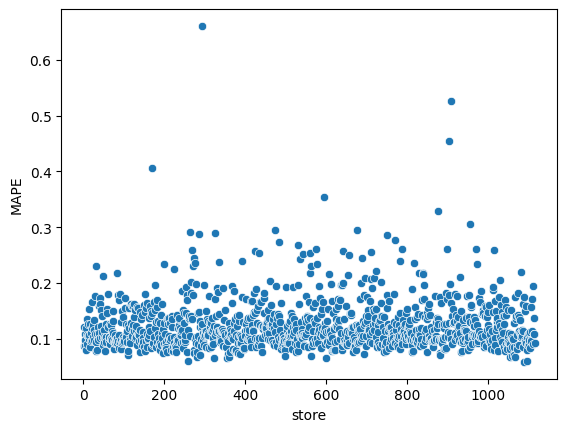

In [ ]:
sns.scatterplot(x = 'store', y = 'MAPE', data = df72);

### 10.2 Total performance

In [104]:
df73 = df72[['predictions', 'worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenarios', 0:'Values'})
df73['Values'] = df73['Values'].map(lambda x: f'R${x:.2f}')
df73

,Scenarios,Values
0,predictions,R$290353280.00
1,worst_scenario,R$289437890.72
2,best_scenario,R$291268672.37


### 10.3 Machine Learning perfomance

In [105]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']

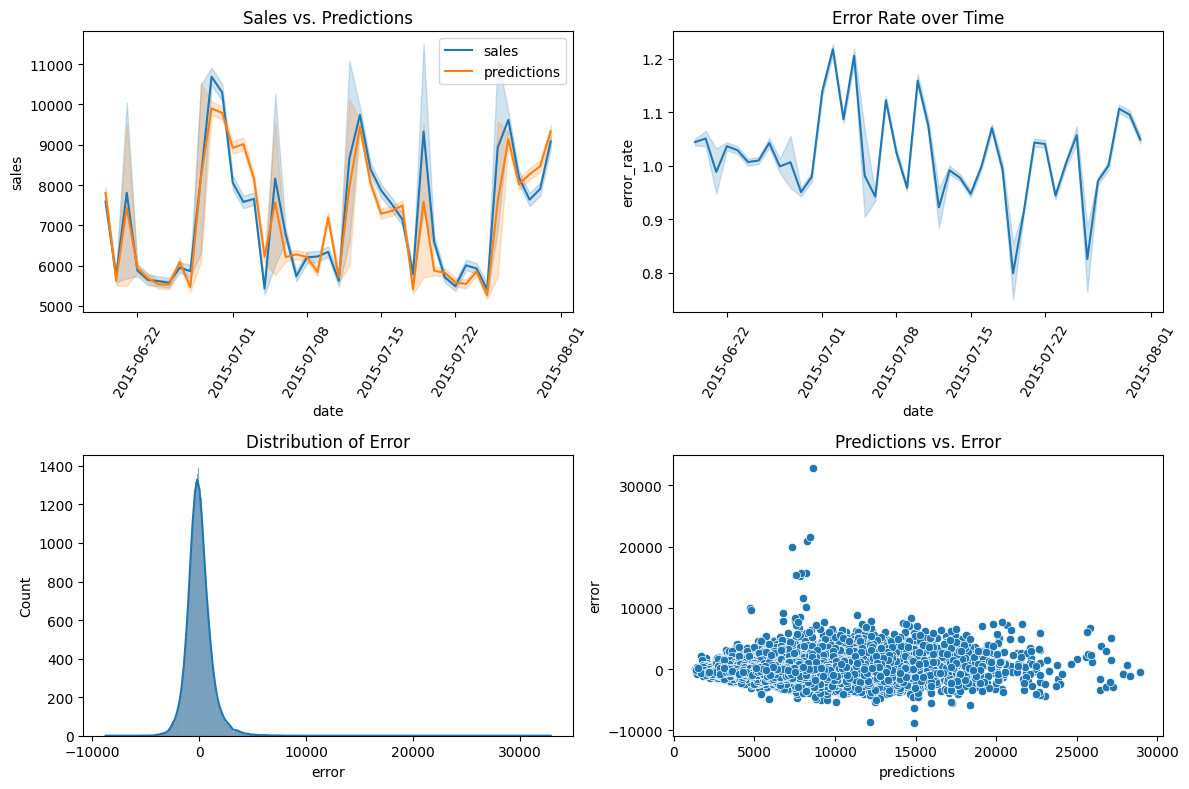

In [106]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df7, label='sales')
sns.lineplot(x='date', y='predictions', data=df7, label='predictions')
plt.xticks(rotation = 60)
plt.title('Sales vs. Predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df7)
plt.xticks(rotation = 60)
plt.title('Error Rate over Time')

plt.subplot(2, 2, 3)
sns.histplot(df7["error"], kde=True)
plt.title('Distribution of Error')

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df7)
plt.title('Predictions vs. Error')

plt.tight_layout()
plt.show()

